# Proyecto de Machine Learning Parte 1 - Poniendo juntas las piezas de Machine Learning

Al leer un libro de data science o seguir un curso puedes sentir que dispones de piezas individuales, pero no sabes cómo unirlas. Dar el siguiente paso y resolver un problema de machine learning completo puede ser desalentador, pero enfrentarse y completar un primer proyecto te dará la confianza para afrontar cualquier problema relacionado con data science. Esta serie de notebooks analizará una solución completa de machine learning con un conjunto de datos del mundo real para que puedas ver cómo se unen todas las piezas.

Seguiremos paso a paso el flujo general de trabajo de machine learning:

1. Limpieza y formateo de datos.
2. Análisis exploratorio de datos.
3. Ingeniería y selección de características.
4. Comparar varios modelos de machine learning en una métrica de rendimiento.
5. Ajuste del hiperparámetro en el mejor modelo.
6. Evaluar el mejor modelo en el conjunto de pruebas.
7. Interpretar los resultados del modelo.
8. Sacar conclusiones y documentar el trabajo.

En el camino veremos cómo cada paso fluye hacia el siguiente y cómo implementar específicamente cada parte en Python.

Definir esta estructura antes de tiempo nos permite ver cómo un paso fluye hacia el otro. Sin embargo, el proceso de machine learning es un procedimiento iterativo, por lo que no siempre seguimos estos pasos de manera lineal. Es posible que volvamos a revisar un paso anterior en función de los resultados de una etapa posterior. Por ejemplo, si bien podemos realizar una selección de características antes de construir cualquier modelo, podemos usar los resultados del modelado para retroceder y seleccionar un conjunto diferente de características. O el modelado puede generar resultados inesperados que signifiquen que queramos explorar nuestros datos desde otro ángulo.

El objetivo a lo largo de esta serie de *notebooks* es mostrar cómo todas las diferentes prácticas de data science se unen para formar un proyecto completo. Trato de centrarme más en la implementación de los métodos en lugar de explicarlos en un nivel bajo, pero he proporcionado recursos para aquellos que desean profundizar. Uno de los mejores libros individuales para aprender lo básico e implementar prácticas de machine learning en Python es [Hands-On Machine Learning with Scikit-Learn and Tensorflow](http://shop.oreilly.com/product/0636920052289.do) de [Aurelion Geron](https://twitter.com/aureliengeron?lang=en).

## Definición del problema

El primer paso es comprender el problema que estamos tratando de resolver y los datos disponibles. En este proyecto, trabajaremos con [datos de energía de edificios disponibles públicamente de la ciudad de Nueva York](http://www.nyc.gov/html/gbee/html/plan/ll84_scores.shtml).

**El objetivo es utilizar los datos de energía para construir un modelo que pueda predecir la puntuación Energy Star de un edificio e interpretar los resultados para encontrar los factores que influyen en dicha puntuación**.

Los datos incluyen la puntuación Energy Star, por tanto, se trata de una tarea de machine learning de regresión supervisada:

+ **Supervisado**: tenemos acceso tanto a las características como al objetivo y nuestro objetivo es entrenar un modelo que pueda aprender un mapeo entre los dos.
+ **Regresión**: la puntuación de Energy Star es una variable continua (en este caso va de 0 a 100).

Queremos desarrollar un modelo que sea a la vez **preciso**: pueda predecir el puntaje Energy Star cerca del valor real, e **interpretable**: podamos entender las predicciones del modelo. Una vez que conozcamos el objetivo, podemos usarlo para guiar nuestras decisiones a medida que profundizamos en los datos y construimos modelos. Durante el entrenamiento, queremos que el modelo aprenda la relación entre las características y la puntuación, por lo que le damos las características y la respuesta. Luego, para probar cómo de bien ha aprendido el modelo, ¡lo evaluamos en un conjunto de pruebas donde nunca ha visto las respuestas!

## Imports

Usaremos las bibliotecas estándar de data science y machine learning: numpy, pandas y scikit-learn. También utilizaremos matplotlib y seaborn para visualización.

In [1]:
# Pandas y numpy para manipulación de datos
import pandas as pd
import numpy as np

# Quitamos los warnings sobre el establecimiento de un valor en una copia de un slice
pd.options.mode.chained_assignment = None

# Mostramos hasta 60 columnas de un dataframe
pd.set_option('display.max_columns', 60)

# Visualización Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Establece el tamaño de fuente por defecto
plt.rcParams['font.size'] = 24

# Herramienta interna ipython para establecer el tamaño de la figura
from IPython.core.pylabtools import figsize

# Visualizción por Seaborn
import seaborn as sns
sns.set(font_scale = 2)

# División de los datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

# Librería para mostrár imágenes
from IPython.display import Image

## Limpieza de datos

Contrariamente a lo que pueda parecer, no todos los conjuntos de datos son un grupo de observaciones perfectamente saneado, sin valores perdidos ni anomalías (como puede creerse observando los conjuntos de datos de [mtcars](http://stat.ethz.ch/R-manual/R-devel/library/datasets/html/mtcars.html) e [iris](https://archive.ics.uci.edu/ml/datasets/iris)). Los datos del mundo real son confusos, lo que significa que debemos [limpiarlos y cambiarlos](https://www.springboard.com/blog/data-wrangling/) a un formato aceptable antes de que podamos comenzar el análisis. La limpieza de datos es una parte poco glamurosa pero necesaria de la mayoría de los problemas reales de data science.

Cargaremos nuestros datos en un `dataframe` de pandas, una de las estructuras de datos más útiles de data science. Piensa en ello como una hoja de cálculo dentro de Python que podemos manipular, limpiar y visualizar fácilmente. Pandas [tiene muchos métodos](http://pandas.pydata.org/pandas-docs/stable/) para ayudar a que el flujo de información de data science / machine learning sea lo más sencillo posible.

In [2]:
# Cargamos los datos en un dataframe 
data = pd.read_csv("./data/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv")

# Mostramos la cabecera del dataframe
data.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,10017,675,3 AVENUE,Manhattan,289356.0,Office,Office,Office,293447,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,5.15506751E7,Not Available,Not Available,38139374.2,1.10827705E7,6962.2,0,6962.2,762051,Not Available,Not Available,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,10032,180,FT WASHINGTON AVENUE,Manhattan,3693539.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181,Not Available,Not Available,Not Available,Not Available,1969,12,100,Whole Building,Whole Building,55,229.8,228.8,24.8,2.4,401.1,Not Available,1.96248472E7,Not Available,Not Available,Not Available,-3.914148026E8,933073441,9330734.4,332365924,9.62613121E7,55870.4,51016.4,4854.1,3889181,Not Available,Not Available,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,10032,3975,BROADWAY,Manhattan,152765.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342,Not Available,Not Available,Not Available,Not Available,1924,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,0,231342,Not Available,Not Available,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...
3,4,4778267,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,10032,161,FT WASHINGTON AVENUE,Manhattan,891040.0,Hos

Echando un vistazo a los datos en bruto, ya podemos ver una serie de problemas que tendremos que resolver. En primer lugar, hay 60 columnas y no sabemos lo que significan muchas de ellas. Todo lo que sabemos de la declaración del problema es que queremos predecir el número en la columna `ENERGY STAR Score`. Algunas de las definiciones de otras columnas pueden ser razonablemente adivinadas, pero otras son difíciles de entender. En machine learning, esto no es realmente un problema, porque dejamos que el modelo decida qué características son importantes. A veces es posible que ni siquiera nos den nombres de columnas ni nos digan lo que estamos pronosticando. No obstante, me gusta entender el problema en la medida de lo posible y, como también queremos interpretar los resultados del modelo, sería una buena idea tener algún conocimiento de las columnas.

Después de mirar el nombre del archivo, `Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv`, busqué "Local Law 84." Al hacerlo, se accede a [esta página web](http://www.nyc.gov/html/gbee/html/plan/ll84.shtml) que nos dice que la Ley Local 84 es un requisito de la Ciudad de Nueva York que establece que todos los edificios mayores de $50,000 ft^2$ deben reportar un determinado conjunto de números relacionados con la energía cada año. Después de buscar un poco más, podemos acceder a [este documento pdf](http://www.nyc.gov/html/gbee/downloads/misc/nyc_benchmarking_disclosure_data_definitions_2017.pdf) detalla el significado de cada columna.

Si bien no necesitamos estudiar cada columna, sería una buena idea comprender al menos el objetivo que queremos predecir. Aquí está la definición para el objetivo `score`:

    Una clasificación percentil de 1 a 100 para tipos de edificios específicos, calculada en Portfolio Manager, basada en el consumo de energía autoinformado para el reporte anual.
    
Eso parece bastante sencillo: el Energy Star Score es un método para clasificar los edificios en términos de eficiencia energética con 1 para los peores y 100 para los mejores. Es una clasificación de percentil relativo, lo que significa que los edificios se califican entre sí y deben mostrar una distribución uniforme en todo el rango de valores.

## Tipos de datos y valores ausentes

El método `dataframe.info` es una forma rápida de evaluar los datos al mostrar los tipos de datos de cada columna y el número de valores que no faltan. Ya al mirar el dataframe puede haber un problema porque los valores faltantes se codifican como "Not Available" en lugar de como `np.nan` (not a number). Esto significa que las columnas con números no se representarán como numéricas porque pandas convierte las columnas con cualquier valor de cadena en columnas de todo cadenas.

In [3]:
# Mostramos los tipos de datos y los valores no faltantes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 60 columns):
Order                                                         11746 non-null int64
Property Id                                                   11746 non-null int64
Property Name                                                 11746 non-null object
Parent Property Id                                            11746 non-null object
Parent Property Name                                          11746 non-null object
BBL - 10 digits                                               11735 non-null object
NYC Borough, Block and Lot (BBL) self-reported                11746 non-null object
NYC Building Identification Number (BIN)                      11746 non-null object
Address 1 (self-reported)                                     11746 non-null object
Address 2                                                     11746 non-null object
Postal Code                                          

Efectivamente, hay una serie de columnas con números que se han registrado como tipos de datos `object`. Estos deberán ser convertidos a tipo de datos `float` antes de que podamos realizar cualquier análisis numérico.

### Convertir datos al tipo correcto

Convertimos las columnas con números en tipos de datos numéricos reemplazando las entradas "Not Available" con `np.nan` que se pueden interpretar como `float`. Luego, convertiremos las columnas que contienen valores numéricos (como pies cuadrados o uso de energía) en tipos de datos numéricos.

In [4]:
# Reemplaza todas las ocurrencias de Not Available por numpy not a number
data = data.replace({'Not Available': np.nan})

# Iterar a través de las columnas
for col in list(data.columns):
    # Selecciona las columnas que deben ser numéricas
    if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in 
        col or 'therms' in col or 'gal' in col or 'Score' in col):
        # Convierte el tipo de dato a float
        data[col] = data[col].astype(float)

In [5]:
# Muestra las estadísticas para cada columna numérica
data.describe()

,Order,Property Id,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract
count,11746.000000,1.174600e+04,1.162800e+04,1.174400e+04,3741.000000,1484.000000,11746.000000,11746.000000,11746.000000,9642.000000,11583.000000,10281.000000,10959.000000,9783.000000,10281.000000,9.000000e+00,2.581000e+03,1.321000e+03,5.940000e+02,1.600000e+01,9.360000e+02,1.030400e+04,9.784000e+03,1.150200e+04,1.096000e+04,1.167200e+04,1.166300e+04,1.168100e+04,1.174600e+04,7.762000e+03,7762.000000,11583.000000,9483.000000,9483.000000,9483.000000,9483.000000,9483.000000
mean,7185.759578,3.642958e+06,1.732695e+05,1.605524e+05,22778.682010,12016.825270,1948.738379,1.289971,98.762557,59.854594,280.071484,309.747466,11.072643,1.901441,417.915709,3.395398e+06,3.186882e+06,5.294367e+06,2.429105e+06,1.193594e+06,2.868907e+08,5.048545e+07,5.364578e+05,5.965472e+06,1.768752e+06,4.553657e+03,2.477937e+03,2.076339e+03,1.673739e+05,1.591798e+04,136.172432,385.908029,40.754379,-73.957057,7.140673,15.771275,4977.596647
std,4323.859984,1.049070e+06,3.367055e+05,3.095746e+05,55094.441422,27959.755486,30.576386,4.017484,7.501603,29.993586,8607.178877,9784.731207,127.733868,97.204587,10530.524339,2.213237e+06,5.497154e+06,5.881863e+06,4.442946e+06,3.558178e+06,3.124603e+09,3.914719e+09,4.022606e+07,3.154430e+07,9.389154e+06,2.041639e+05,1.954498e+05,5.931295e+04,3.189238e+05,1.529524e+05,1730.726938,9312.736225,0.080120,0.046337,3.954129,15.674375,13520.422990
min,1.000000,7.365000e+03,5.002800e+04,5.400000e+01,0.000000,0.000000,1600.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.085973e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.690797e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.313430e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,40.516065,-74.243582,1.000000,1.000000,1.000000
25%,3428.250000,2.747222e+06,6.524000e+04,6.520100e+04,4000.000000,1720.750000,1927.000000,1.000000,100.000000,37.000000,61.800000,65.100000,3.800000,0.100000,103.500000,1.663594e+06,2.550378e+05,2.128213e+06,0.000000e+00,5.698020e+04,4.320254e+06,1.098251e+06,1.176952e+04,1.043673e+06,3.019974e+05,3.287000e+02,1.474500e+02,9.480000e+01,6.699400e+04,2.595400e+03,27.150000,99.400000,40.707226,-73.984662,4.000000,4.000000,100.000000
50%,6986.500000,3.236404e+06,9.313850e+04,9.132400e+04,8654.000000,5000.000000,1941.000000,1.000000,100.000000,65.000000,78.500000,82.500000,5.300000,0.500000,129.400000,4.328815e+06,1.380138e+06,4.312984e+06,0.000000e+00,2.070020e+05,9.931240e+06,4.103962e+06,4.445525e+04,1.855196e+06,5.416312e+05,5.002500e+02,2.726000e+02,1.718000e+02,9.408000e+04,4.692500e+03,45.095000,124.900000,40.759130,-73.962810,7.000000,9.000000,201.000000
75%,11054.500000,4.409092e+06,1.596140e+05,1.532550e+05,20000.000000,12000.000000,1966.000000,1.000000,100.000000,85.000000,97.600000,102.500000,9.200000,0.700000,167.200000,4.938947e+06,4.445808e+06,6.514520e+06,4.293825e+06,2.918332e+0

## Datos ausentes

Ahora que tenemos los tipos de datos de columna correctos, podemos comenzar el análisis observando el porcentaje de valores faltantes en cada columna. Estos pueden surgir por muchas razones y deben completarse o eliminarse antes de capacitar a un modelo de machine learning. Primero, veamos cuántos valores faltan en cada columna. La siguiente función calcula el número de valores faltantes y el porcentaje de los valores totales que faltan para cada columna.

In [6]:
# Función para calcular los valores faltantes por columna
def missing_values_table(df):
    # Total de valores faltantes
    mis_val = df.isnull().sum()
        
    # Porcentaje de valores faltantes
    mis_val_percent = 100 * df.isnull().sum() / len(df)
        
    # Hacemos una tabla con los resultados
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
    # Renombramos las columnas
    mis_val_table_ren_columns = mis_val_table.rename(columns = {
        0 : 'Valores Faltantes', 
        1 : '% de Valores Total'})
        
    # Ordena la tabla por porcentaje de faltantes, descendentemente
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% de Valores Total', ascending=False).round(1)
        
    # Imprime alguna información de resumen
    print ("Tu dataframe tiene " + str(df.shape[1]) + " columnas.\n"      
        "Existen " + str(mis_val_table_ren_columns.shape[0]) +
        " columnas que tienen valores faltantes.")
        
    # Devuelve el dataframe con la información faltante
    return mis_val_table_ren_columns

In [7]:
missing_values_table(data)

Tu dataframe tiene 60 columnas.
Existen 46 columnas que tienen valores faltantes.


,Valores Faltantes,% de Valores Total
Fuel Oil #1 Use (kBtu),11737,99.9
Diesel #2 Use (kBtu),11730,99.9
Address 2,11539,98.2
Fuel Oil #5 & 6 Use (kBtu),11152,94.9
District Steam Use (kBtu),10810,92.0
Fuel Oil #4 Use (kBtu),10425,88.8
3rd Largest Property Use Type - Gross Floor Area (ft²),10262,87.4
3rd Largest Property Use Type,10262,87.4
Fuel Oil #2 Use (kBtu),9165,78.0
2nd Largest Property Use Type,8005,68.2


Si bien siempre deberemos tener cuidado al eliminar la información, si una columna tiene un alto porcentaje de valores faltantes, probablemente no sea útil para nuestro modelo. El umbral para eliminar columnas dependerá del problema. Para este proyecto, eliminaremos cualquier columna con más de 50% de valores faltantes. En general, ten cuidado al eliminar cualquier información, ya que incluso si no existe para todas las observaciones, puede ser útil para predecir el valor objetivo.

In [8]:
# Obtenemos las columnas con > 50% de valores faltantes
missing_df = missing_values_table(data);
missing_columns = list(missing_df[missing_df['% de Valores Total'] > 50].index)
print('Hemos eliminado %d columnas.' % len(missing_columns))

Tu dataframe tiene 60 columnas.
Existen 46 columnas que tienen valores faltantes.
Hemos eliminado 11 columnas.


In [9]:
# Eliminamos las columnas del dataframe
data = data.drop(columns = list(missing_columns))

El resto de los valores faltantes deberán completarse utilizando una estrategia adecuada antes de realizar el machine learning.

## Análisis exploratorio de datos (EDA)

Ahora que hemos completado el tedioso, pero necesario, paso de la limpieza de datos, ¡podemos continuar explorando nuestros datos! El [análisis exploratorio de datos (EDA)](https://en.wikipedia.org/wiki/Exploratory_data_analysis) es un proceso abierto en el que calculamos estadísticas y hacemos cifras para encontrar tendencias, anomalías, patrones o relaciones dentro de los datos.

En resumen, el objetivo de EDA es aprender lo que nuestros datos pueden decirnos. Generalmente comienza con una visión general de alto nivel, luego se reduce a áreas específicas a medida que encontramos partes interesantes de los datos. Los hallazgos pueden ser interesantes por derecho propio o pueden usarse para informar nuestras opciones de modelado, por ejemplo, ayudándonos a decidir qué características usar.

Para comenzar la EDA, nos centraremos en una sola variable, la `Energy Star Score`, porque este es el objetivo de nuestros modelos de machine learning. Podemos cambiar el nombre de la columna a `score` por simplicidad y luego comenzar a explorar este valor.

### Gráfico de variables únicas

Un histograma es una forma simple pero efectiva de visualizar la distribución de una sola variable y es fácil de hacer usando `matplotlib`.

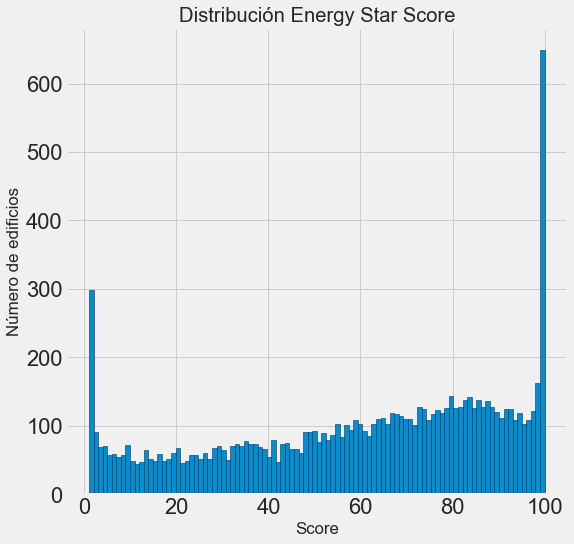

In [10]:
figsize(8, 8)

# Renombramos a score
data = data.rename(columns = {'ENERGY STAR Score': 'score'})

# Histograma de Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(data['score'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('Score'); plt.ylabel('Número de edificios'); 
plt.title('Distribución Energy Star Score');

¡Esto parece bastante sospechoso! La puntuación de Energy Star es un rango percentil, lo que significa que esperaríamos ver una distribución uniforme, con cada puntuación asignada al mismo número de edificios (esperaríamos ver una distribución completamente plana donde cada puntuación representaría el 1% de la distribución, aproximadamente 90 edificios). Sin embargo, un número desproporcionado de edificios tiene la puntuación más alta, 100, o la más bajo, 1 (más alto es mejor para la puntuación Energy Star).

Si volvemos a la definición de la puntuación, vemos que se basa en el "consumo de energía autoinformado" que podría explicar las puntuaciones muy altas. Pedir a los propietarios de edificios que informen sobre su propio consumo de energía es como pedirles a los estudiantes que reporten sus propias puntuaciones en una prueba. Como resultado, esta no es probablemente la medida más objetiva de la eficiencia energética de un edificio.

Si tuviéramos una cantidad de tiempo ilimitada, podríamos investigar por qué tantos edificios tienen puntuaciones muy altas y muy bajas, lo que podríamos hacer al seleccionar estos edificios y ver qué tienen en común. Sin embargo, nuestro objetivo es solo predecir la puntuación y no diseñar un mejor método para puntuar edificios. Podemos hacer una nota en nuestro informe de que las puntuaciones tienen una distribución sospechosa, pero nuestro enfoque principal es predecir la puntuación.

Para contrastar la puntuación de Energy Star, podemos observar la intensidad de uso de energía (EUI, por sus siglas en inglés), que es el uso de energía total dividido por la superficie cuadrada del edificio. En este caso, el uso de energía no es autoinformado, por lo que podría ser una medida más objetiva de la eficiencia energética de un edificio. Además, este no es un rango de percentil, por lo que los valores absolutos son importantes y esperamos que sean aproximadamente normalmente distribuidos con quizás algunos valores atípicos en el extremo alto o bajo.

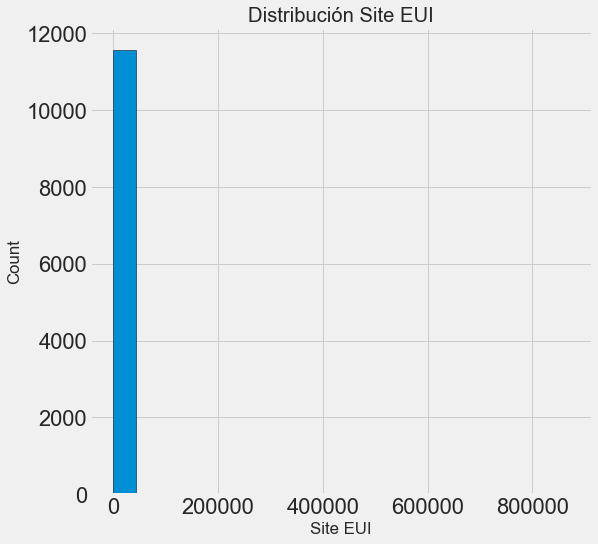

In [11]:
# Histograma de Site EUI
figsize(8, 8)
plt.hist(data['Site EUI (kBtu/ft²)'].dropna(), bins = 20, edgecolor = 'black');
plt.xlabel('Site EUI'); 
plt.ylabel('Count'); plt.title('Distribución Site EUI');

Bueno, esto nos muestra que tenemos otro problema: ¡los valores atípicos! El gráfico es increíblemente sesgado debido a la presencia de unos pocos edificios con puntuaciones muy altas. Parece que tendremos que tomar un pequeño desvío para lidiar con los valores atípicos. Veamos las estadísticas de esta característica.

In [12]:
data['Site EUI (kBtu/ft²)'].describe()

count     11583.000000
mean        280.071484
std        8607.178877
min           0.000000
25%          61.800000
50%          78.500000
75%          97.600000
max      869265.000000
Name: Site EUI (kBtu/ft²), dtype: float64

In [13]:
data['Site EUI (kBtu/ft²)'].dropna().sort_values().tail(10)

3173     51328.8
3170     51831.2
3383     78360.1
8269     84969.6
3263     95560.2
8268    103562.7
8174    112173.6
3898    126307.4
7       143974.4
8068    869265.0
Name: Site EUI (kBtu/ft²), dtype: float64

¡Un edificio está claramente muy por encima del resto!

In [14]:
data.loc[data['Site EUI (kBtu/ft²)'] == 869265, :]

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
8068,9984,4414323,234 Skillman,Not Applicable: Standalone Property,Not Applicable: Standalone Property,3028937502,3028937502,"3390250 , 3338313",234 Skillman avenue,11211,234,SKILLMAN AVENUE,Brooklyn,61811.0,Multifamily Housing,Multifamily Housing,Multifamily Housing,56900.0,2004,1,90,Whole Building,NaN,1.0,869265.0,939329.0,9.9,9393.0,986366.0,4.945919e+10,534458968.8,1983655.6,563239.6,2627199.1,2627015.0,184.1,56900.0,2547.9,44.78,912801.1,05/01/2017 11:34:14 PM,NaN,In Compliance,40.716233,-73.94141,1.0,34.0,477.0,East Williamsburg ...


¡Podría valer la pena que alguien haga un seguimiento con el propietario de este edificio! Sin embargo, ese no es nuestro problema y solo necesitamos averiguar cómo manejar esta información. Los valores atípicos pueden ocurrir por muchas razones: errores tipográficos, fallas en los dispositivos de medición, unidades incorrectas o pueden ser valores legítimos pero extremos. Los valores atípicos pueden descartar un modelo porque no son indicativos de la distribución real de los datos.

### Eliminando valores atípicos

Cuando eliminamos los valores atípicos, debemos tener cuidado de no desechar las medidas simplemente porque se ven extrañas. Pueden ser el resultado de un fenómeno real que deberíamos investigar más a fondo. Al eliminar los valores atípicos, trato de ser lo más conservador posible. Para este proyecto, eliminaremos anomalías basadas en la [definición de valores extremos](https://people.richland.edu/james/lecture/m170/ch03-pos.html):

+ Por debajo del primer cuartil - 3 * rango intercuartil
+ Por encima del tercer cuartil + 3 * range rango intercuartil

En este caso, solo eliminaré el único punto extremo y veré cómo se ve la distribución.

In [15]:
# Calculamos el primer y tercer cuartil
first_quartile = data['Site EUI (kBtu/ft²)'].describe()['25%']
third_quartile = data['Site EUI (kBtu/ft²)'].describe()['75%']

# Rango intercuartil
iqr = third_quartile - first_quartile

# Eliminamos valores atípicos
data = data[(data['Site EUI (kBtu/ft²)'] > (first_quartile - 3 * iqr)) &
            (data['Site EUI (kBtu/ft²)'] < (third_quartile + 3 * iqr))]

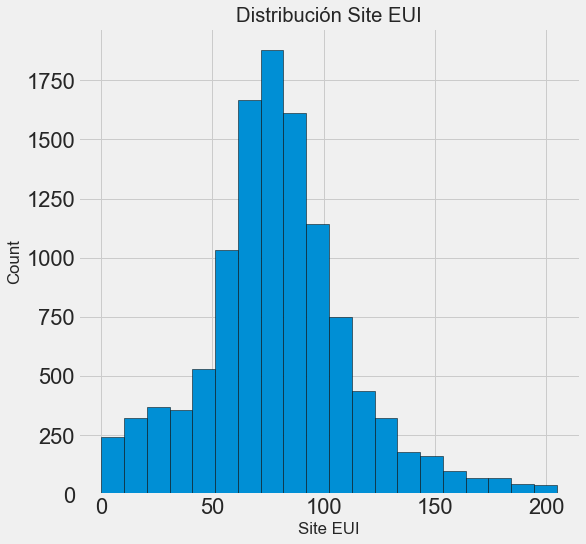

In [16]:
# Histograma de Site EUI
figsize(8, 8)
plt.hist(data['Site EUI (kBtu/ft²)'].dropna(), bins = 20, edgecolor = 'black');
plt.xlabel('Site EUI'); 
plt.ylabel('Count'); plt.title('Distribución Site EUI');

Después de eliminar los valores atípicos, podemos volver al análisis.

Este gráfico parece un poco menos sospechoso y está casi distribuido normalmente con una cola larga en el lado derecho (tiene un sesgo positivo).

Aunque esta podría ser una medida más objetiva, nuestro objetivo aún es predecir la puntuación Energy Star, por lo que volveremos a examinar esa variable. Incluso si la puntuación no es una buena medida, nuestra tarea es predecirlo, ¡así que eso es lo que trataremos de hacer! En el informe final a la compañía, señalaré que esto podría no ser una medida objetiva, y sería una buena idea usar diferentes métricas para determinar la eficiencia de un edificio. Además, si tuviéramos más tiempo para este proyecto, podría ser interesante echar un vistazo a los edificios con puntuaciones de 1 y 100 para ver si tienen algo en común.

### Buscando relaciones

Una parte importante de EDA es buscar relaciones entre las características y el objetivo. Las variables que están correlacionadas con el objetivo son útiles para un modelo porque pueden usarse para predecir el objetivo. Una forma de examinar el efecto de una variable categórica (que toma solo un conjunto limitado de valores) en el objetivo es a través de un gráfico de densidad utilizando la biblioteca `seaborn`. 

[Los gráficos de densidad se pueden considerar como un histograma suavizado](https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0). Si coloreamos las curvas de densidad con una variable categórica, esto nos mostrará cómo cambia la distribución en función de la clase.

El primer gráfico que haremos muestra la distribución de puntuaciones por tipo de propiedad. Para no confudir el plot, limitaremos el gráfico a los tipos de construcción que tengan más de 100 observaciones en el conjunto de datos.

In [17]:
# Creamos una lista de edificios con más de 100 observaciones
types = data.dropna(subset=['score'])
types = types['Largest Property Use Type'].value_counts()
types = list(types[types.values > 100].index)

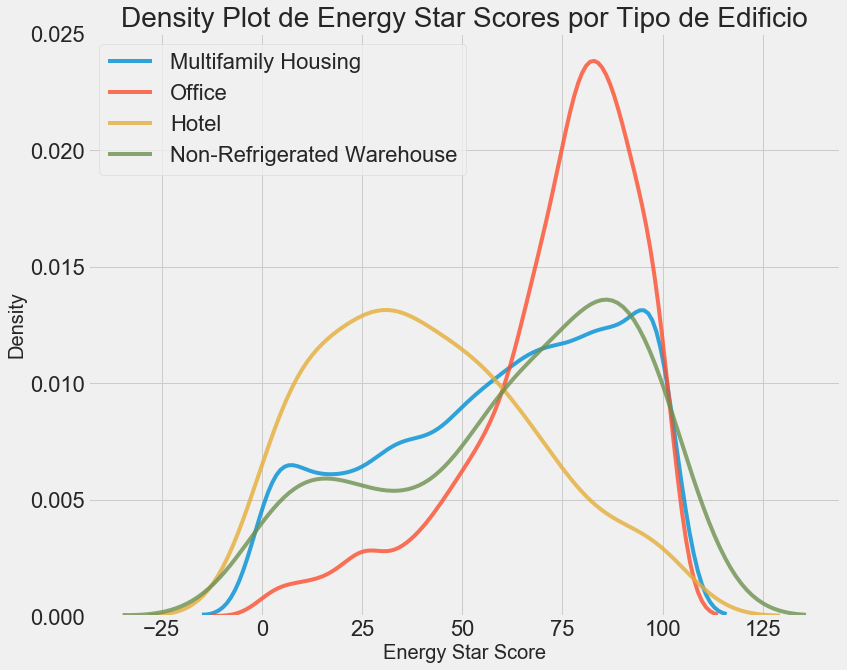

In [18]:
# Dibujamos la distribución de puntuaciones por categoría de edificio
figsize(12, 10)

# Dibujamos cada edificio
for b_type in types:
    # Seleccionamos el tipo de edificio
    subset = data[data['Largest Property Use Type'] == b_type]
    
    # Density plot de Energy Star scores
    sns.kdeplot(subset['score'].dropna(), label = b_type, shade = False, alpha = 0.8);
    
# Etuqietamos el plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot de Energy Star Scores por Tipo de Edificio', size = 28);

A partir de este gráfico, podemos ver que el tipo de construcción tiene un efecto en la puntuación (las puntuaciones negativas en la gráfica son un artefacto del procedimiento del [kernel density estimation](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/)). Aunque inicialmente iba a centrarme en las columnas numéricas para predecir la puntuación, este gráfico nos dice que debemos incluir el tipo de propiedad porque esta información puede ser útil para determinar la puntuación. Como el tipo de construcción es una variable categórica, tendrá que estar codificada antes de poder incorporarla a un modelo de machine learning.

Para examinar otra variable categórica, el municipio, podemos hacer el mismo gráfico, pero esta vez con el color del municipio.

In [19]:
# Creamos una lista de municipios con más de 100 observaciones
boroughs = data.dropna(subset=['score'])
boroughs = boroughs['Borough'].value_counts()
boroughs = list(boroughs[boroughs.values > 100].index)

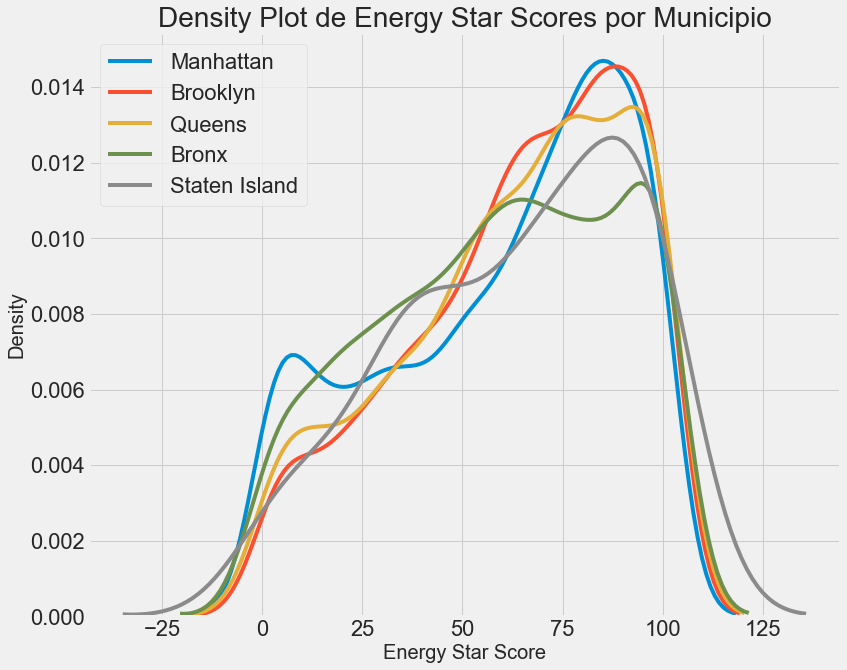

In [20]:
# Dibujamos la distribución de puntuaciones por municipio
figsize(12, 10)

# Dibujamos cada municipio
for borough in boroughs:
    # Seleccionamos el municipio
    subset = data[data['Borough'] == borough]
    
    # Density plot de Energy Star scores
    sns.kdeplot(subset['score'].dropna(), label = borough);
    
# label the plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot de Energy Star Scores por Municipio', size = 28);

El municipio no parece tener un impacto tan grande en la puntuación como el tipo de edificio. No obstante, podríamos incluirlo en nuestro modelo porque existen pequeñas diferencias entre los municipios.

### Correlaciones entre características y objetivo

Para cuantificar las relaciones entre variables, podemos utilizar el [coeficiente de correlación de Pearson](http://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/). Esta es una medida de la fuerza y la dirección de una relación lineal entre dos variables. Una puntuación de +1 es una relación positiva perfectamente lineal y una puntuación de -1 es una relación lineal perfectamente negativa. A continuación se muestran varios valores del coeficiente de correlación y cómo aparecen gráficamente.:

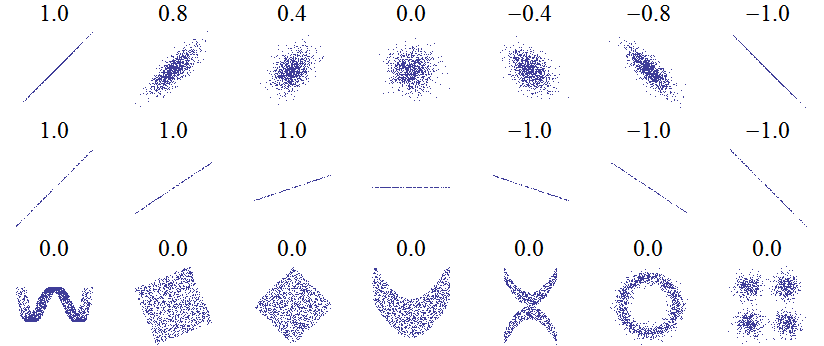

In [21]:
Image(filename="./images/correlation_examples.png")

Aunque puede haber relaciones no lineales entre las características y los objetivos y los coeficientes de correlación no tienen en cuenta las interacciones entre las características, las relaciones lineales son una buena manera de comenzar a explorar tendencias en los datos. Luego podemos usar estos valores para seleccionar las características que emplearemos en nuestro modelo.

El siguiente código calcula los coeficientes de correlación entre todas las variables y la puntuación.

In [22]:
# Encuentra todas las correlaciones y las ordena
correlations_data = data.corr()['score'].sort_values()

# Imprime la correlaciones más negativas
print(correlations_data.head(15), '\n')

# Imprime las correlaciones más positivas
print(correlations_data.tail(15))

Site EUI (kBtu/ft²)                                          -0.723864
Weather Normalized Site EUI (kBtu/ft²)                       -0.713993
Weather Normalized Source EUI (kBtu/ft²)                     -0.645542
Source EUI (kBtu/ft²)                                        -0.641037
Weather Normalized Site Electricity Intensity (kWh/ft²)      -0.358394
Weather Normalized Site Natural Gas Intensity (therms/ft²)   -0.346046
Direct GHG Emissions (Metric Tons CO2e)                      -0.147792
Weather Normalized Site Natural Gas Use (therms)             -0.135211
Natural Gas Use (kBtu)                                       -0.133648
Year Built                                                   -0.121249
Total GHG Emissions (Metric Tons CO2e)                       -0.113136
Electricity Use - Grid Purchase (kBtu)                       -0.050639
Weather Normalized Site Electricity (kWh)                    -0.048207
Latitude                                                     -0.048196
Proper

Hay varias correlaciones negativas fuertes entre las características y el objetivo. Las correlaciones más negativas con la puntuación son las diferentes categorías de Intensidad de uso de energía (EUI), `Site EUI (kBtu/ft²)` y `EWeather Normalized Site EUI (kBtu/ft²)` (varían ligeramente en la forma en que se calculan). La EUI es la cantidad de energía utilizada por un edificio dividida por la superficie cuadrada de los edificios y está destinada a ser una medida de la eficiencia de un edificio, siendo una puntuación más baja mejor. Intuitivamente, estas correlaciones tienen sentido: a medida que aumenta la EUI, la puntuación Energy Star tiende a disminuir.

Para tener en cuenta las posibles relaciones no lineales, podemos tomar la raíz cuadrada y las transformaciones logarítmicas de las características y luego calcular los coeficientes de correlación con la puntuación. Para intentar capturar cualquier posible relación entre el municipio o el tipo de edificio (recuerde que estas son variables categóricas) y la puntuación tendremos que codificar estas columnas.

En el siguiente código, tomamos las transformaciones de logaritmo y raíz cuadrada de las variables numéricas, codificamos las dos variables categóricas seleccionadas (tipo de construcción y municipio), calculamos las correlaciones entre todas las características y la puntuación, y mostramos las 15 principales correlaciones positivas y las 15 más negativas. 

In [23]:
# Seleccionamos las columnas numéricas
numeric_subset = data.select_dtypes('number')

# Creamos columnas con la raiz cuadrada y el logaritmo de las columnas numéricas
for col in numeric_subset.columns:
    # Saltamos la columna Energy Star Score
    if col == 'score':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Seleccionamos las columnas categóricas
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# Las codificamos
categorical_subset = pd.get_dummies(categorical_subset)

# Unimos los dos dataframes usando concat
# Nos aseguramos usar axis = 1 para ejecutar una unión por columna
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Eliminamos los edificios sin energy star score
features = features.dropna(subset = ['score'])

# Encontramos las correlaciones con score 
correlations = features.corr()['score'].dropna().sort_values()

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [24]:
# Mostramos las principales correlaciones negativas
correlations.head(15)

Site EUI (kBtu/ft²)                                            -0.723864
Weather Normalized Site EUI (kBtu/ft²)                         -0.713993
sqrt_Site EUI (kBtu/ft²)                                       -0.699817
sqrt_Weather Normalized Site EUI (kBtu/ft²)                    -0.689019
sqrt_Weather Normalized Source EUI (kBtu/ft²)                  -0.671044
sqrt_Source EUI (kBtu/ft²)                                     -0.669396
Weather Normalized Source EUI (kBtu/ft²)                       -0.645542
Source EUI (kBtu/ft²)                                          -0.641037
log_Source EUI (kBtu/ft²)                                      -0.622892
log_Weather Normalized Source EUI (kBtu/ft²)                   -0.620329
log_Site EUI (kBtu/ft²)                                        -0.612039
log_Weather Normalized Site EUI (kBtu/ft²)                     -0.601332
log_Weather Normalized Site Electricity Intensity (kWh/ft²)    -0.424246
sqrt_Weather Normalized Site Electricity Intensity 

In [25]:
# Mostramos las principales correlaciones positivas
correlations.tail(15)

sqrt_Order                                                         0.028662
Borough_Queens                                                     0.029545
Largest Property Use Type_Supermarket/Grocery Store                0.030038
Largest Property Use Type_Residence Hall/Dormitory                 0.035407
Order                                                              0.036827
Largest Property Use Type_Hospital (General Medical & Surgical)    0.048410
Borough_Brooklyn                                                   0.050486
log_Community Board                                                0.055495
Community Board                                                    0.056612
sqrt_Community Board                                               0.058029
sqrt_Council District                                              0.060623
log_Council District                                               0.061101
Council District                                                   0.061639
Largest Prop

Después de transformar las características, las relaciones más fuertes siguen siendo las relacionadas con Energy Use Intensity (EUI). Las transformaciones de log y raíz cuadrada no parecen haber resultado en relaciones más sólidas. No hay relaciones lineales positivas fuertes, aunque sí vemos que el tipo de edificio "oficina" (`Largest Property Use Type_Office`) está ligeramente correlacionado positivamente con la puntuación. Esta variable es una representación codificada de las variables categóricas para el tipo de construcción.

Podemos usar estas correlaciones para realizar la selección de características. En este momento, vamos a graficar la correlación más significativa (en términos de valor absoluto) en el conjunto de datos que es `Site EUI (kBtu/ft^2)`. Podemos colorear el gráfico por tipo de edificio para mostrar cómo afecta eso a la relación.

### Gráfico de dos variables

Para visualizar la relación entre dos variables, utilizamos un diagrama de dispersión (scatterplot). También podemos incluir variables adicionales utilizando aspectos como el color de los marcadores o el tamaño de los marcadores. Aquí trazaremos dos variables numéricas una contra otra y usaremos el color para representar una tercera variable categórica.

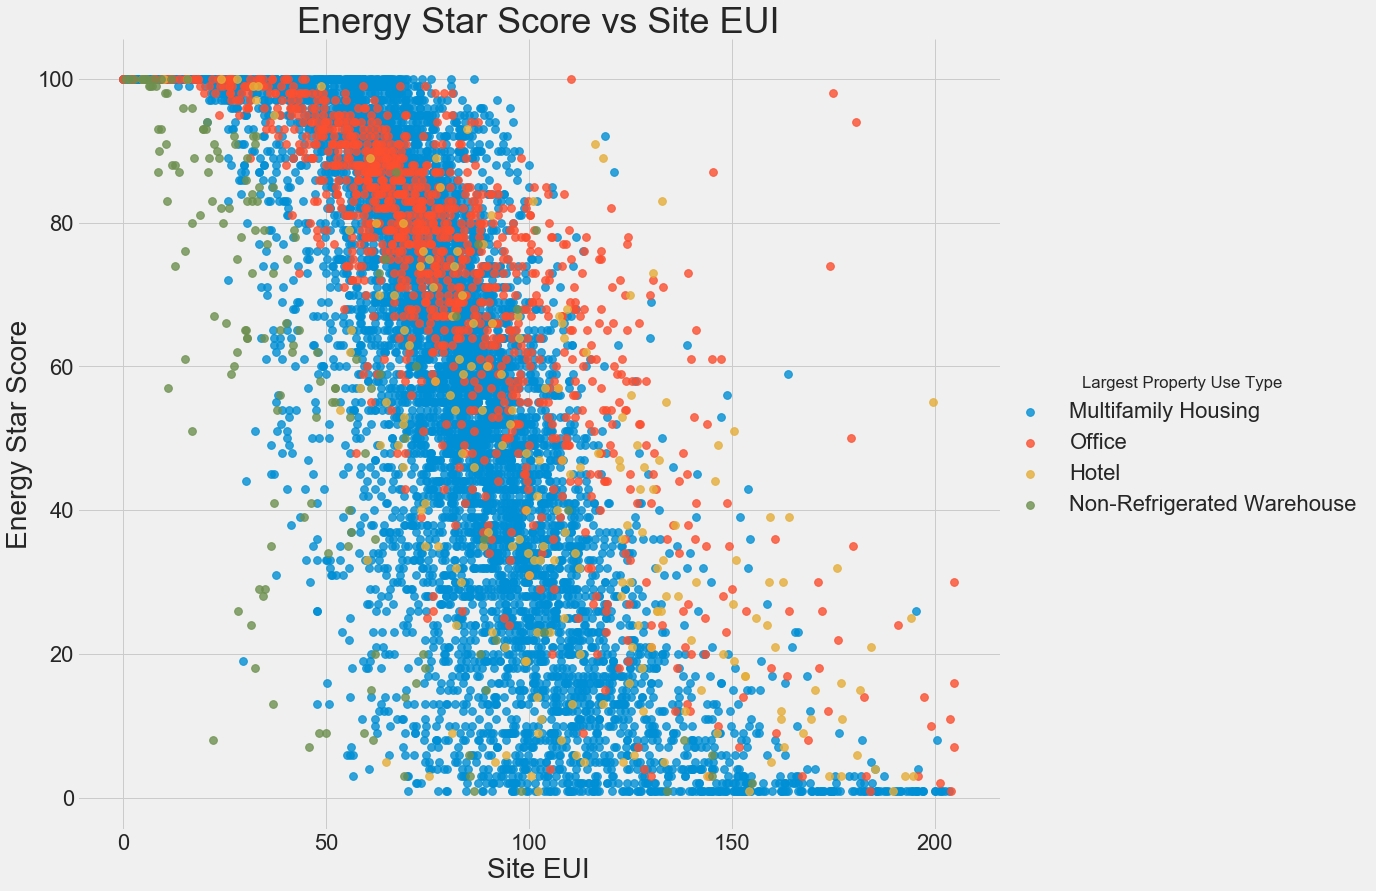

In [26]:
figsize(12, 10)

# Extraemos los tipos de edificio
features['Largest Property Use Type'] = data.dropna(subset = ['score'])['Largest Property Use Type']

# Limitamos a tipos de edificio con más de 100 observaciones
features = features[features['Largest Property Use Type'].isin(types)]

# Usamos seaborn para dibujar un scatterplot de Score vs Log Source EUI
sns.lmplot('Site EUI (kBtu/ft²)', 'score', 
          hue = 'Largest Property Use Type', data = features,
          scatter_kws = {'alpha': 0.8, 's': 60}, fit_reg = False,
          height = 12, aspect = 1.2);

# Etiquetamos el plot
plt.xlabel("Site EUI", size = 28)
plt.ylabel('Energy Star Score', size = 28)
plt.title('Energy Star Score vs Site EUI', size = 36);

Existe una clara relación negativa entre Site EUI y la puntuación. La relación no es perfectamente lineal (se ve con un coeficiente de correlación de -0.7, pero parece que esta característica será importante para predecir la puntuación de un edificio). Una relación que se mantiene estable en todos los tipos de edificios.

### Pairs Plots

El gráfico final de exploración que haremos se conoce como Pairs Plot. Esta es una gran herramienta de exploración porque nos permite ver las relaciones entre varios pares de variables, así como las distribuciones de variables individuales. Aquí estamos utilizando la biblioteca de visualización `seaborn` y la función `PairGrid` para crear un gráfico de pares con diagramas de dispersión en el triángulo superior, histogramas en la diagonal y gráficos de densidad de kernel 2D y coeficientes de correlación en el triángulo inferior.

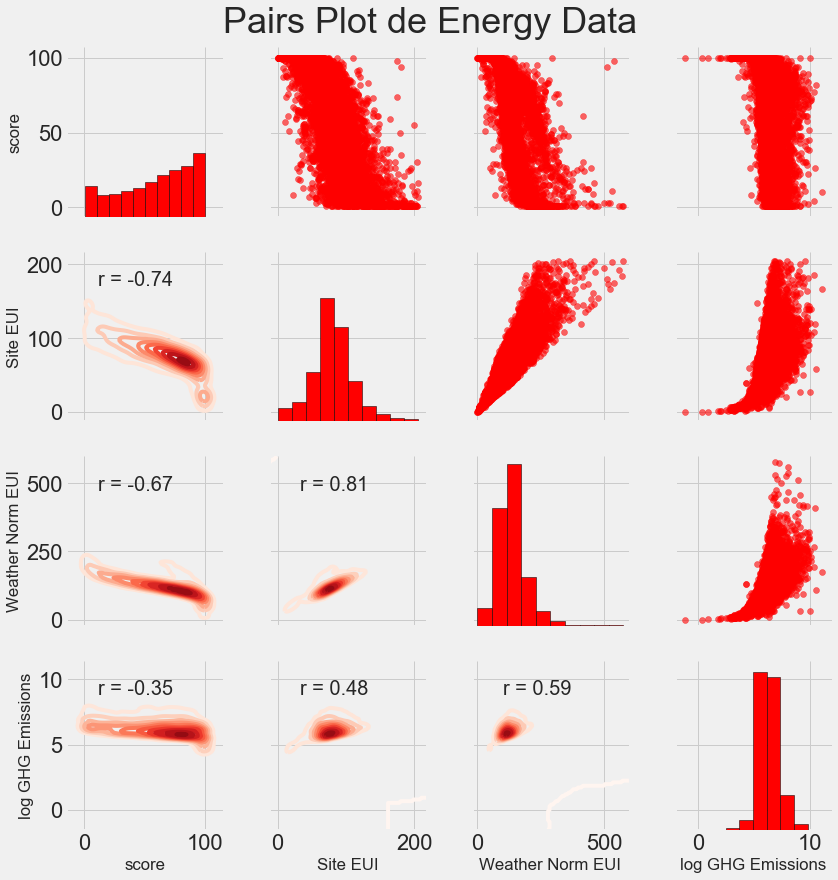

In [27]:
# Extraemos las columnas a dibujar
plot_data = features[['score', 'Site EUI (kBtu/ft²)', 
                      'Weather Normalized Source EUI (kBtu/ft²)', 
                      'log_Total GHG Emissions (Metric Tons CO2e)']]

# Reemplaza la información con nan
plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

# Renombramos columnas
plot_data = plot_data.rename(columns = {'Site EUI (kBtu/ft²)': 'Site EUI', 
                                        'Weather Normalized Source EUI (kBtu/ft²)': 'Weather Norm EUI',
                                        'log_Total GHG Emissions (Metric Tons CO2e)': 'log GHG Emissions'})

# Eliminamos valores na
plot_data = plot_data.dropna()

# Función para calcular el coeficiente de correlación entre dos columnas
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Crea el objeto pairgrid
grid = sns.PairGrid(data = plot_data, height = 3)

# En la parte superior está el scatter plot
grid.map_upper(plt.scatter, color = 'red', alpha = 0.6)

# En la diagonal está el histograma
grid.map_diag(plt.hist, color = 'red', edgecolor = 'black')

# En la parte inferior está la correlación y el plot de densidad
grid.map_lower(corr_func);
grid.map_lower(sns.kdeplot, cmap = plt.cm.Reds)

# Título global para el gráfico
plt.suptitle('Pairs Plot de Energy Data', size = 36, y = 1.02);

Para ver las interacciones entre las variables, buscamos donde una fila intersecciona con una columna. Por ejemplo, para ver la correlación de `Weather Norm EUI` con `score`, buscamos en la fila `Weather Norm EUI` y en la columna `score` y vemos un coeficiente de correlación de -0.67. Si observamos la gráfica superior derecha, podemos ver un diagrama de dispersión de esta relación. Además de verse geniales, los gráficos como estos pueden ayudarnos a decidir qué variables incluir en el modelado.

## Ingeniería y selección de características (Feature Engineering and Selection)

Ahora que hemos explorado las tendencias y las relaciones dentro de los datos, podemos trabajar en la ingeniería de un conjunto de características para nuestros modelos. Podemos utilizar los resultados de la EDA para informar esta ingeniería de características (Feature Engineering). En particular, aprendimos lo siguiente de EDA que puede ayudarnos en la ingeniería / selección de características:

+ La distribución de puntuación varía según el tipo de construcción y, en menor medida, el municipio. Aunque nos enfocaremos en las características numéricas, también deberíamos incluir estas dos características categóricas en el modelo.
+ Tomar la transformación logarítmica de las características no produce aumentos significativos en las correlaciones lineales entre las características y la puntuación.

Antes de seguir avanzando, ¡debemos definir qué son la ingeniería de características y la selección! Estas definiciones son informales y tienen una considerable superposición, pero me gusta pensar en ellas como dos procesos separados:

* __[Ingeniería de características](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)__: el proceso de tomar datos sin procesar y extraer o crear nuevas características que permiten a un modelo de machine learning aprender un mapeo entre estas características y el objetivo. Esto podría significar tomar transformaciones de variables, como hicimos con el logaritmo y la raíz cuadrada, o variables categóricas codificadas para que puedan usarse en un modelo. En general, creo que la ingeniería de características agrega características adicionales derivadas de los datos en bruto.

* __[Selección de características](https://machinelearningmastery.com/an-introduction-to-feature-selection/)__: el proceso de selección de las características más relevantes en sus datos. "Lo más relevante" puede depender de muchos factores, pero podría ser algo tan simple como la correlación más alta con el objetivo o las características con la [mayor varianza](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html). En la selección de caracerísticas, eliminamos aquellas que no ayudan a nuestro modelo a aprender la relación entre las características y el objetivo. Esto puede ayudar al modelo a generalizarse mejor a nuevos datos y resultados en un modelo más interpretable. En general, considero que la selección de características es una función de **sustracción**, por lo que solo nos quedan las más importantes.

La ingeniería y selección de características son procesos iterativos que generalmente requieren varios intentos para hacerlo bien. A menudo, usaremos los resultados del modelado, como la importancia de las características de un bosque aleatorio, para volver y rehacer la selección de características, o más tarde podremos descubrir relaciones que requieren la creación de nuevas variables. Además, estos procesos generalmente incorporan una mezcla de conocimiento de dominio y calidad estadística de los datos.

La [ingeniería y selección de características](https://www.featurelabs.com/blog/secret-to-data-science-success/) a menudo tiene los mayores retornos de inversión de  tiempo en un problema de machine learning. Puede tomar bastante tiempo lograrlo, pero a menudo es más importante que el algoritmo exacto y los hiperparámetros utilizados para el modelo. Si no le damos al modelo los datos correctos entonces lo estamos configurando para que falle y ¡no debemos esperar que aprendan!

En este proyecto, realizaremos los siguientes pasos para la ingeniería de características:

+ Seleccionar solo las variables numéricas y dos variables categóricas (Property Use Type y Municipio)
+ Añadir la transformación logarítmica de las variables numéricas. Agregar características transformadas puede ayudar a nuestro modelo a aprender relaciones no lineales dentro de los datos. Tomar la raíz cuadrada, el logaritmo natural, etc. es una práctica común en data science y puede basarse en el conocimiento del dominio o en lo que funciona mejor en la práctica. Aquí incluiremos el logaritmo natural de todas las características numéricas.
+ Codificar las variables categóricas. La codificación es necesaria para incluir variables categóricas en un modelo. Un algoritmo de machine learning no puede entender el tipo de edificio "oficina", por ejemplo, por lo que tenemos que registrarlo como 1 si el edificio es una oficina y 0 en caso contrario contrario.

Para la selección de características, haremos lo siguiente:

+ Eliminar [características colineales](https://statinfer.com/204-1-9-issue-of-multicollinearity-in-python/).

Discutiremos la colinealidad (también llamada [multicolinealidad](https://en.wikipedia.org/wiki/Multicollinearity)) cuando lleguemos a ese proceso.

El siguiente código selecciona las funciones numéricas, agrega la transformación logarítmica de todas las funciones numéricas, selecciona y codifica las características categóricas y lo une conjuntamente al resto de características del dataset.

In [28]:
# Hacemos una copia del dataframe original
features = data.copy()

# Seleccionamos las columnas numéricas
numeric_subset = data.select_dtypes('number')

# Creamos columnas con el logaritmo de las columnas numéricas
for col in numeric_subset.columns:
    # Nos saltamos la columna Energy Star Score
    if col == 'score':
        next
    else:
        numeric_subset['log_' + col] = np.log(numeric_subset[col])
        
# Seleccionamos las columnas categóricas
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# Las codificamos
categorical_subset = pd.get_dummies(categorical_subset)

# Unimos los dos dataframes usando concat
# asegurándonos de usar axis = 1 para ejecutar una unión por columna
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

features.shape

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


(11319, 110)

En este punto, tenemos 11.319 observaciones (edificios) con 109 características diferentes (una columna es la puntuación). Es probable que no todas estas características sean importantes para predecir la puntuación, y varias de estas características también son redundantes porque están altamente correlacionadas. Nos ocuparemos de este segundo tema a continuación.

### Eliminar características colineales

Las [características altamente colineales](http://psychologicalstatistics.blogspot.com/2013/11/multicollinearity-and-collinearity-in.html) tienen un coeficiente de correlación significativo entre ellas. Por ejemplo, en nuestro conjunto de datos, `Site EUI` y `Weather Norm EUI` están altamente correlacionados porque son solo medios ligeramente diferentes para calcular la intensidad del uso de energía.

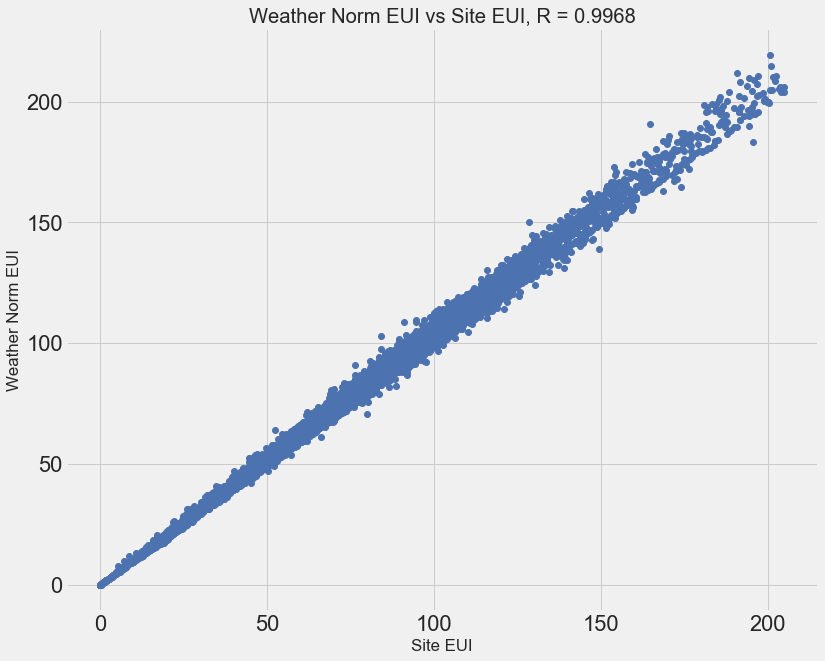

In [29]:
plot_data = data[['Weather Normalized Site EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)']].dropna()

plt.plot(plot_data['Site EUI (kBtu/ft²)'], plot_data['Weather Normalized Site EUI (kBtu/ft²)'], 'bo')
plt.xlabel('Site EUI'); plt.ylabel('Weather Norm EUI')
plt.title('Weather Norm EUI vs Site EUI, R = %0.4f' % np.corrcoef(data[['Weather Normalized Site EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)']].dropna(), rowvar=False)[0][1]);

Si bien las variables en un conjunto de datos generalmente están correlacionadas en un grado pequeño, las variables altamente colineales pueden ser redundantes en el sentido de que solo necesitamos conservar una de las características para proporcionar a nuestro modelo la información necesaria.

La eliminación de características colineales es un método para reducir la complejidad del modelo al disminuir el número de características y puede ayudar a aumentar la generalización del modelo. También puede ayudarnos a interpretar el modelo porque solo tenemos que preocuparnos por una sola variable, como EUI, en lugar de cómo EUI y weather normalized EUI afectan a la puntuación.

Existen varios métodos para eliminar características colineales, como el uso del [factor de inflación de la varianza (Variance Inflation Factor)](http://www.statisticshowto.com/variance-inflation-factor/). Usaremos una métrica más simple y eliminaremos las características que tengan un coeficiente de correlación por encima de un cierto umbral entre sí (no con la puntuación porque queremos variables que estén altamente correlacionadas con la puntuación). Echa un vistazo a este [notebook en Kaggle](https://www.kaggle.com/robertoruiz/dealing-with-multicollinearity/code).

El siguiente código elimina las características colineales en función de un umbral que seleccionamos para los coeficientes de correlación mediante la eliminación de una de las dos características que se comparan. También imprime las correlaciones que elimina para que podamos ver el efecto de ajustar el umbral. Usaremos un umbral de 0.6 que elimina una de un par de características si el coeficiente de correlación entre las características excede este valor.

In [30]:
def remove_collinear_features(x, threshold):
    '''
    Objetivo:
        Eliminar características colineales en un dataframe con un coeficiente
        de correlación mayor que el umbral. Eliminar características colineales
        puede ayudar a un modelo a generalizar y mejorar su interpretabilidad.
        
    Inputs: 
        threshold: cualquier característica con correlaciones mayores a este valor serán eliminadas
    
    Output: 
        dataframe que contiene solo las características no altamente colineales
    '''
    
    # No queremos eliminar correlaciones entre between Energy Star Score
    y = x['score']
    x = x.drop(columns = ['score'])
    
    # Calcula la matriz de correlación
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Itera a través de la matriz de correlación y compara correlaciones
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # Si la correlación excede el umbral
            if val >= threshold:
                # Imprime las características correlacionadas y el valor de correlación
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Elimina una de cada par de columnas correlacionadas
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    x = x.drop(columns = ['Weather Normalized Site EUI (kBtu/ft²)', 
                          'Water Use (All Water Sources) (kgal)',
                          'log_Water Use (All Water Sources) (kgal)',
                          'Largest Property Use Type - Gross Floor Area (ft²)'])
    
    # Añade score de nuevo a los datos
    x['score'] = y
               
    return x

In [31]:
# Elimina las características colineales superiores a un coeficiente de correlación especificado
features = remove_collinear_features(features, 0.6);

Weather Normalized Source EUI (kBtu/ft²) | Site EUI (kBtu/ft²) | 0.83
Weather Normalized Source EUI (kBtu/ft²) | Weather Normalized Site EUI (kBtu/ft²) | 0.81
Weather Normalized Source EUI (kBtu/ft²) | Weather Normalized Site Electricity Intensity (kWh/ft²) | 0.85
Natural Gas Use (kBtu) | Largest Property Use Type - Gross Floor Area (ft²) | 0.61
Weather Normalized Site Natural Gas Use (therms) | Largest Property Use Type - Gross Floor Area (ft²) | 0.61
Electricity Use - Grid Purchase (kBtu) | DOF Gross Floor Area | 0.63
Electricity Use - Grid Purchase (kBtu) | Largest Property Use Type - Gross Floor Area (ft²) | 0.67
Weather Normalized Site Electricity (kWh) | DOF Gross Floor Area | 0.66
Weather Normalized Site Electricity (kWh) | Largest Property Use Type - Gross Floor Area (ft²) | 0.66
Total GHG Emissions (Metric Tons CO2e) | DOF Gross Floor Area | 0.75
Total GHG Emissions (Metric Tons CO2e) | Largest Property Use Type - Gross Floor Area (ft²) | 0.79
Total GHG Emissions (Metric Tons 

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal


Largest Property Use Type_Office | Largest Property Use Type_Multifamily Housing | 0.63


In [32]:
# Elimina cualquier columna con todos los valores na
features  = features.dropna(axis=1, how = 'all')
features.shape

(11319, 65)

Nuestro conjunto de datos final ahora tiene 64 características (una de las columnas es el objetivo). Esto todavía es bastante, pero en su mayoría es porque tenemos las variables categóricas codificadas. Además, si bien una gran cantidad de características puede ser problemática para modelos como la regresión lineal, los modelos como el bosque aleatorio realizan una selección de características implícita y determinan automáticamente qué características son importantes durante el entrenamiento. Hay otros pasos de selección de características a seguir, pero por ahora mantendremos todas las características que tenemos y veremos cómo funciona el modelo.

### Selección de características adicionales

Hay muchos más métodos para la [selección de características](https://scikit-learn.org/stable/modules/feature_selection.html). Algunos métodos populares incluyen el [análisis de componentes principales (PCA)](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf), que transforma las características en un número reducido de dimensiones que conservan la mayor varianza, o el [análisis de componentes independientes (ICA)](http://cs229.stanford.edu/notes/cs229-notes11.pdf), cuyo objetivo es encontrar las fuentes independientes en un conjunto de características. Sin embargo, aunque estos métodos son efectivos para reducir la cantidad de características, crean nuevas características que no tienen un significado físico y, por lo tanto, hacen que la interpretación de un modelo sea casi imposible.

¡Estos métodos son muy útiles para tratar con datos de alta dimensión y sugeriría [leer más sobre el tema](https://machinelearningmastery.com/feature-selection-machine-learning-python/) si planea tratar problemas de machine learning!

## División en conjunto de entrenamiento y prueba

En machine learning, siempre tenemos que separar nuestras características en dos conjuntos:

1. **Conjunto de entrenamiento**, el cual proporcionamos a nuestro modelo durante el entrenamiento junto con las respuestas para que pueda aprender un mapeo entre las características y el objetivo.
2. **Conjunto de pruebas** que utilizamos para evaluar el mapeo aprendido por el modelo. El modelo nunca ha visto las respuestas en el conjunto de pruebas, pero en cambio, debe hacer predicciones usando solo las características. Como sabemos las respuestas verdaderas para el conjunto de pruebas, podemos comparar las predicciones de prueba con los objetivos de prueba reales para obtener una estimación de cómo de bien se desempeñará nuestro modelo cuando se implemente en el mundo real.

Para nuestro problema, primero extraeremos todos los edificios sin una puntuación de Energy Star (no sabemos la respuesta correcta para estos edificios, por lo que no serán útiles para la capacitación o las pruebas). Luego, dividiremos los edificios con una puntuación Energy Star en un conjunto de prueba correspondiente al 30% de los edificios y un conjunto de entrenamiento correspondiente al 70% de los edificios.

Dividir los datos en un conjunto de entrenamiento y pruebas al azar es simple usando scikit-learn. Podemos establecer el estado aleatorio de la división para garantizar resultados consistentes.

In [33]:
# Extraemos los edificiones sin puntuación y los edificios con puntuación
no_score = features[features['score'].isna()]
score = features[features['score'].notnull()]

print(no_score.shape)
print(score.shape)

(1858, 65)
(9461, 65)


In [34]:
# Separamos las características y los objetivos
features = score.drop(columns='score')
targets = pd.DataFrame(score['score'])

# Replace the inf and -inf with nan (required for later imputation)
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Divide 70% para entrenamiento y 30% para pruebas
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(6622, 64)
(2839, 64)
(6622, 1)
(2839, 1)


Tenemos 1.858 edificios sin puntuación, 6.622 edificios con puntuación en el conjunto de entrenamiento, y 2.839 edificios con puntuación en el conjunto de prueba. Tenemos un paso final que hacer en este notebook: ¡determinar una línea base sencilla para que nuestros modelos puedan vencer!

## Estableciendo una línea base

Es importante establecer una línea base sencilla antes de comenzar a hacer modelos de machine larning. Si los modelos que construimos no pueden superar una suposición simple y sencilla, entonces tendremos que admitir que machine learning no es adecuado para este problema. Esto podría deberse a que no estamos usando los modelos correctos, porque necesitamos más datos o porque existe una solución más simple que no requiere machine learning. Establecer una línea base es crucial para que no terminemos construyendo un modelo de machine learning solo para darnos cuenta de que no podemos resolver el problema.

Para una tarea de regresión, una buena línea base sencilla es predecir el valor medio del objetivo en el conjunto de entrenamiento para todos los ejemplos en el conjunto de prueba. Esto es fácil de implementar y establece una barrera relativamente baja para nuestros modelos: si no pueden hacerlo mejor que adivinar el valor medio, entonces tendremos que replantearnos nuestro enfoque.

### Métrica: Error Medio Absoluto

Hay una serie de métricas utilizadas en las tareas de machine learning y puede ser [difícil saber cuál elegir](https://www.analyticsvidhya.com/blog/2016/02/7-important-model-evaluation-error-metrics/). La mayoría de las veces dependerá del problema en particular y si tiene un objetivo específico para optimizar. Me gusta [el consejo de Andrew Ng de usar una única métrica de rendimiento de valor real](https://www.coursera.org/learn/machine-learning-projects/lecture/wIKkC/single-number-evaluation-metric) para comparar modelos porque simplifica el proceso de evaluación. En lugar de calcular múltiples métricas y tratar de determinar cómo de importante es cada una, debemos usar una sola. En este caso, debido a que estamos haciendo una regresión, el [__error medio absoluto__](https://people.duke.edu/~rnau/compare.htm) es una métrica adecuada. Esto también se puede interpretar porque representa el promedio de nuestra estimación en las mismas unidades que el valor objetivo.

La siguiente función calcula el error medio absoluto entre los valores reales y las predicciones.

In [35]:
# Función para calcular el error medio absoluto
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

Ahora podemos hacer la conjetura promedio y evaluarla en el conjunto de pruebas.

In [36]:
baseline_guess = np.median(y)

print('La baseline es una puntuación de %0.2f' % baseline_guess)
print("Ejecución de la Baseline en el conjunto de pruebas: MAE = %0.4f" % mae(y_test, baseline_guess))

La baseline es una puntuación de 66.00
Ejecución de la Baseline en el conjunto de pruebas: MAE = 24.5164


Esto muestra que nuestra estimación promedio en el conjunto de pruebas es alrededor de 25 puntos. Las puntuaciones se encuentran entre 1 y 100, por lo que esto significa el error promedio de un método sencillo si se trata de un 25%. ¡El método simple de adivinar el valor medio de entrenamiento nos proporciona una base de referencia baja para que nuestros modelos puedan vencer!

## Conclusiones

En este notebook, hemos llevado a cabo los tres primeros [pasos de un problema de machine learning](https://towardsdatascience.com/the-7-steps-of-machine-learning-2877d7e5548e?gi=30cd995093a9):

1. Limpiar y formatear los datos en bruto.
2. Realizar un análisis exploratorio de datos.
3. Desarrollar un conjunto de características para entrenar a nuestro modelo utilizando ingeniería de características y selección de características.

También completamos la tarea crucial de establecer una métrica de referencia para poder determinar si nuestro modelo es mejor que adivinar.

Con suerte, estás empezando a tener una idea de cómo fluye cada parte del flujo hacia la siguiente: limpiar los datos y colocarlos en el formato adecuado nos permite realizar un análisis exploratorio de los datos. La EDA luego informa nuestras decisiones en la etapa de ingeniería de características y selección. Estos tres pasos generalmente se realizan en este orden, aunque es posible que regresemos más tarde y realicemos más EDA o ingeniería de características basada en nuestros resultados de modelado. Data science es un proceso iterativo en el que siempre estamos buscando formas de mejorar nuestro trabajo anterior. Esto significa que no tenemos que hacer las cosas perfectas la primera vez (aunque podemos hacer nuestro mejor esfuerzo) porque casi siempre hay oportunidades para revisar nuestras decisiones una vez que sepamos más sobre el problema.

En la segunda parte, nos centraremos en la implementación de varios métodos de machine learning, en la selección del mejor modelo y en la optimización de nuestro problema mediante el ajuste del hiperparámetro con la validación cruzada. Como paso final aquí, guardaremos los conjuntos de datos que desarrollamos para usar de nuevo en la siguiente parte.

In [37]:
# Salvamos los datos sin puntuación, los de entrenamiento y los de prueba
no_score.to_csv('./data/no_score.csv', index = False)
X.to_csv('./data/training_features.csv', index = False)
X_test.to_csv('./data/testing_features.csv', index = False)
y.to_csv('./data/training_labels.csv', index = False)
y_test.to_csv('./data/testing_labels.csv', index = False)